In [ ]:
from google.colab import drive
drive.mount('/content/drive')

root = '/content/drive/My Drive/surely_not_sarcasm_data/'

Mounted at /content/drive


In [ ]:
!pip install transformers
!cp -r '$root/utils' .

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import transformers

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from torch.utils.data import TensorDataset, DataLoader, RandomSampler

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import get_linear_schedule_with_warmup

from utils.pytorch import train_model, test_model

transformers.logging.set_verbosity_error()

sns.set_style('whitegrid');
sns.set_context('notebook', font_scale=1.1);

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# prepare data

In [ ]:
df = pd.read_csv(root+'data/all_balanced_partly_preprocessed.csv')
df.head()

,label,comment,parent_comment
0,0,NC and NH.,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",deadass don't kill my buzz
4,0,I could use one of those tools.,Yep can confirm I saw the tool they use for th...


In [ ]:
X = df[['comment', 'parent_comment']]
y = df['label'].values

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.3, random_state=61) # 83, 91, 61
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, stratify=y_val, test_size=0.5, random_state=61)

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((876854, 2), (187897, 2), (187898, 2))

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

# content-based

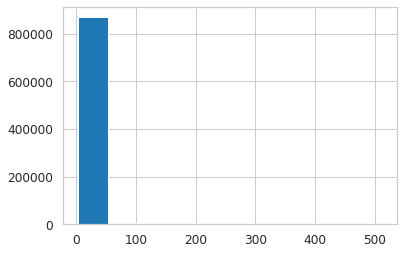

In [ ]:
lengths = [len(tokenizer.encode(x, max_length=512, truncation=True)) for x in X_train['comment']]
plt.hist(lengths);

In [ ]:
np.quantile(lengths, 0.9)

28.0

In [ ]:
max_len = 28

In [ ]:
encoding_train = tokenizer(
    X_train['comment'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    return_token_type_ids=False,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

encoding_val = tokenizer(
    X_val['comment'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    return_token_type_ids=False,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

encoding_test = tokenizer(
    X_test['comment'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    return_token_type_ids=False,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

In [ ]:
X_train, X_train_mask = encoding_train['input_ids'], encoding_train['attention_mask']
X_val, X_val_mask = encoding_val['input_ids'], encoding_val['attention_mask']
X_test, X_test_mask = encoding_test['input_ids'], encoding_test['attention_mask']

In [ ]:
y_train, y_val, y_test = torch.tensor(y_train), torch.tensor(y_val), torch.tensor(y_test)

In [ ]:
batch_size = 128

train_data = TensorDataset(X_train, X_train_mask, y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(X_val, X_val_mask, y_val)
val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

test_data = TensorDataset(X_test, X_test_mask, y_test)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
dataloaders = {'train': train_dataloader, 'val': val_dataloader, 'test': test_dataloader}
data_size = {'train': len(train_data), 'val': len(val_data), 'test': len(test_data)}

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
).to(device);

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifi

In [ ]:
epochs = 3
total_steps = len(train_dataloader) * epochs

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
# 83
best_model, history = train_model(model, criterion, optimizer, scheduler, epochs, dataloaders, data_size, device, rep=1000)


======== Epoch 1 / 3 ========
Training...
Batch 1,000 of 6,851. Elapsed: 168.78 s.
Batch 2,000 of 6,851. Elapsed: 337.52 s.
Batch 3,000 of 6,851. Elapsed: 506.48 s.
Batch 4,000 of 6,851. Elapsed: 675.66 s.
Batch 5,000 of 6,851. Elapsed: 845.17 s.
Batch 6,000 of 6,851. Elapsed: 1014.85 s.
== train == loss: 0.5140 accuracy: 0.7440
== val == loss: 0.4928 accuracy: 0.7605

======== Epoch 2 / 3 ========
Training...
Batch 1,000 of 6,851. Elapsed: 170.15 s.
Batch 2,000 of 6,851. Elapsed: 340.31 s.
Batch 3,000 of 6,851. Elapsed: 510.55 s.
Batch 4,000 of 6,851. Elapsed: 680.83 s.
Batch 5,000 of 6,851. Elapsed: 851.31 s.
Batch 6,000 of 6,851. Elapsed: 1021.88 s.
== train == loss: 0.4598 accuracy: 0.7811
== val == loss: 0.4820 accuracy: 0.7692

======== Epoch 3 / 3 ========
Training...
Batch 1,000 of 6,851. Elapsed: 170.69 s.
Batch 2,000 of 6,851. Elapsed: 341.42 s.
Batch 3,000 of 6,851. Elapsed: 512.16 s.
Batch 4,000 of 6,851. Elapsed: 682.93 s.
Batch 5,000 of 6,851. Elapsed: 853.76 s.
Batch 6,

In [ ]:
# 91
best_model, history = train_model(model, criterion, optimizer, scheduler, epochs, dataloaders, data_size, device, rep=1000)


======== Epoch 1 / 3 ========
Training...
Batch 1,000 of 6,851. Elapsed: 171.01 s.
Batch 2,000 of 6,851. Elapsed: 341.93 s.
Batch 3,000 of 6,851. Elapsed: 512.91 s.
Batch 4,000 of 6,851. Elapsed: 683.88 s.
Batch 5,000 of 6,851. Elapsed: 854.88 s.
Batch 6,000 of 6,851. Elapsed: 1025.77 s.
== train == loss: 0.5147 accuracy: 0.7439
== val == loss: 0.4842 accuracy: 0.7650

======== Epoch 2 / 3 ========
Training...
Batch 1,000 of 6,851. Elapsed: 171.00 s.
Batch 2,000 of 6,851. Elapsed: 341.94 s.
Batch 3,000 of 6,851. Elapsed: 512.88 s.
Batch 4,000 of 6,851. Elapsed: 683.82 s.
Batch 5,000 of 6,851. Elapsed: 854.71 s.
Batch 6,000 of 6,851. Elapsed: 1025.55 s.
== train == loss: 0.4607 accuracy: 0.7809
== val == loss: 0.4804 accuracy: 0.7707

======== Epoch 3 / 3 ========
Training...
Batch 1,000 of 6,851. Elapsed: 170.86 s.
Batch 2,000 of 6,851. Elapsed: 341.69 s.
Batch 3,000 of 6,851. Elapsed: 512.55 s.
Batch 4,000 of 6,851. Elapsed: 683.35 s.
Batch 5,000 of 6,851. Elapsed: 854.20 s.
Batch 6,

In [ ]:
# 61
best_model, history = train_model(model, criterion, optimizer, scheduler, epochs, dataloaders, data_size, device, rep=1000)


======== Epoch 1 / 3 ========
Training...
Batch 1,000 of 6,851. Elapsed: 170.60 s.
Batch 2,000 of 6,851. Elapsed: 341.07 s.
Batch 3,000 of 6,851. Elapsed: 511.60 s.
Batch 4,000 of 6,851. Elapsed: 682.00 s.
Batch 5,000 of 6,851. Elapsed: 852.18 s.
Batch 6,000 of 6,851. Elapsed: 1022.40 s.
== train == loss: 0.5135 accuracy: 0.7442
== val == loss: 0.4947 accuracy: 0.7576

======== Epoch 2 / 3 ========
Training...
Batch 1,000 of 6,851. Elapsed: 170.38 s.
Batch 2,000 of 6,851. Elapsed: 340.62 s.
Batch 3,000 of 6,851. Elapsed: 510.89 s.
Batch 4,000 of 6,851. Elapsed: 681.09 s.
Batch 5,000 of 6,851. Elapsed: 851.25 s.
Batch 6,000 of 6,851. Elapsed: 1021.44 s.
== train == loss: 0.4599 accuracy: 0.7811
== val == loss: 0.4864 accuracy: 0.7673

======== Epoch 3 / 3 ========
Training...
Batch 1,000 of 6,851. Elapsed: 170.27 s.
Batch 2,000 of 6,851. Elapsed: 340.49 s.
Batch 3,000 of 6,851. Elapsed: 510.71 s.
Batch 4,000 of 6,851. Elapsed: 680.93 s.
Batch 5,000 of 6,851. Elapsed: 851.15 s.
Batch 6,

In [ ]:
y_pred, y_test = test_model(best_model, dataloaders['test'], data_size['test'], device)

test accuracy: 0.7673


In [ ]:
torch.save(best_model.state_dict(), root+'models/distilbert.pth')

In [ ]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [ ]:
# all the parameters
sum(p.numel() for p in best_model.parameters())

66955010

In [ ]:
# trainable parameters
sum(p.numel() for p in best_model.parameters() if p.requires_grad)

66955010

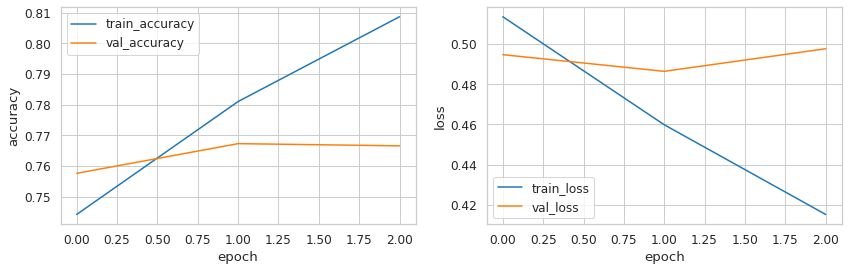

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14,4))

for i, which in enumerate(['accuracy', 'loss']):
    ax = axes[i]
    ax.plot([float(tensor) for tensor in history['train_'+which]], label='train_'+which);
    ax.plot([float(tensor) for tensor in history['val_'+which]], label='val_'+which);
    ax.set_xlabel('epoch');
    ax.set_ylabel(which);
    ax.legend();

# context-based

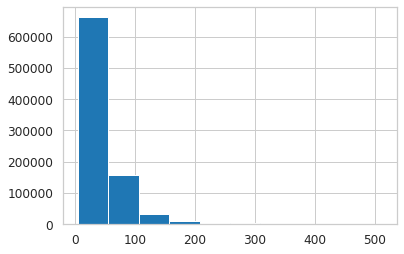

In [ ]:
comment_parent = zip(X_train['comment'].tolist(), X_train['parent_comment'].tolist())
lengths = [len(tokenizer.encode(x, y, max_length=512, truncation=True)) for x, y in comment_parent]
plt.hist(lengths);

In [ ]:
int(np.quantile(lengths, 0.85))

72

In [ ]:
max_len = 72

In [ ]:
encoding_train = tokenizer(
    X_train['parent_comment'].tolist(),
    X_train['comment'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    return_token_type_ids=False,
    padding='max_length',
    truncation='longest_first',
    return_attention_mask=True,
    return_tensors='pt'
)

encoding_val = tokenizer(
    X_val['parent_comment'].tolist(),
    X_val['comment'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    return_token_type_ids=False,
    padding='max_length',
    truncation='longest_first',
    return_attention_mask=True,
    return_tensors='pt'
)

encoding_test = tokenizer(
    X_test['parent_comment'].tolist(),
    X_test['comment'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    return_token_type_ids=False,
    padding='max_length',
    truncation='longest_first',
    return_attention_mask=True,
    return_tensors='pt'
)

In [ ]:
X_train, X_train_mask = encoding_train['input_ids'], encoding_train['attention_mask']
X_val, X_val_mask = encoding_val['input_ids'], encoding_val['attention_mask']
X_test, X_test_mask = encoding_test['input_ids'], encoding_test['attention_mask']

In [ ]:
y_train, y_val, y_test = torch.tensor(y_train), torch.tensor(y_val), torch.tensor(y_test)

In [ ]:
batch_size = 128

train_data = TensorDataset(X_train, X_train_mask, y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(X_val, X_val_mask, y_val)
val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

test_data = TensorDataset(X_test, X_test_mask, y_test)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
dataloaders = {'train': train_dataloader, 'val': val_dataloader, 'test': test_dataloader}
data_size = {'train': len(train_data), 'val': len(val_data), 'test': len(test_data)}

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
).to(device);

In [ ]:
epochs = 3
total_steps = len(train_dataloader) * epochs

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
# 83
best_model, history = train_model(model, criterion, optimizer, scheduler, epochs, dataloaders,
                                  data_size, device, rep=1000)


======== Epoch 1 / 3 ========
Training...
Batch 1,000 of 6,851. Elapsed: 380.73 s.
Batch 2,000 of 6,851. Elapsed: 760.51 s.
Batch 3,000 of 6,851. Elapsed: 1140.55 s.
Batch 4,000 of 6,851. Elapsed: 1520.67 s.
Batch 5,000 of 6,851. Elapsed: 1900.84 s.
Batch 6,000 of 6,851. Elapsed: 2281.15 s.
== train == loss: 0.5061 accuracy: 0.7489
== val == loss: 0.4768 accuracy: 0.7700

======== Epoch 2 / 3 ========
Training...
Batch 1,000 of 6,851. Elapsed: 380.72 s.
Batch 2,000 of 6,851. Elapsed: 761.49 s.
Batch 3,000 of 6,851. Elapsed: 1142.28 s.
Batch 4,000 of 6,851. Elapsed: 1523.12 s.
Batch 5,000 of 6,851. Elapsed: 1903.98 s.
Batch 6,000 of 6,851. Elapsed: 2284.95 s.
== train == loss: 0.4432 accuracy: 0.7908
== val == loss: 0.4630 accuracy: 0.7774

======== Epoch 3 / 3 ========
Training...
Batch 1,000 of 6,851. Elapsed: 380.99 s.
Batch 2,000 of 6,851. Elapsed: 762.06 s.
Batch 3,000 of 6,851. Elapsed: 1143.32 s.
Batch 4,000 of 6,851. Elapsed: 1524.65 s.
Batch 5,000 of 6,851. Elapsed: 1906.12 s.

In [ ]:
# 91
best_model, history = train_model(model, criterion, optimizer, scheduler, epochs, dataloaders,
                                  data_size, device, rep=1000)


======== Epoch 1 / 3 ========
Training...
Batch 1,000 of 6,851. Elapsed: 379.66 s.
Batch 2,000 of 6,851. Elapsed: 759.10 s.
Batch 3,000 of 6,851. Elapsed: 1138.56 s.
Batch 4,000 of 6,851. Elapsed: 1518.05 s.
Batch 5,000 of 6,851. Elapsed: 1897.58 s.
Batch 6,000 of 6,851. Elapsed: 2277.17 s.
== train == loss: 0.5071 accuracy: 0.7480
== val == loss: 0.4710 accuracy: 0.7724

======== Epoch 2 / 3 ========
Training...
Batch 1,000 of 6,851. Elapsed: 379.64 s.
Batch 2,000 of 6,851. Elapsed: 759.38 s.
Batch 3,000 of 6,851. Elapsed: 1139.15 s.
Batch 4,000 of 6,851. Elapsed: 1519.15 s.
Batch 5,000 of 6,851. Elapsed: 1899.01 s.
Batch 6,000 of 6,851. Elapsed: 2278.98 s.
== train == loss: 0.4440 accuracy: 0.7911
== val == loss: 0.4649 accuracy: 0.7813

======== Epoch 3 / 3 ========
Training...
Batch 1,000 of 6,851. Elapsed: 380.26 s.
Batch 2,000 of 6,851. Elapsed: 760.46 s.
Batch 3,000 of 6,851. Elapsed: 1140.78 s.
Batch 4,000 of 6,851. Elapsed: 1521.30 s.
Batch 5,000 of 6,851. Elapsed: 1901.99 s.

In [ ]:
# 61
best_model, history = train_model(model, criterion, optimizer, scheduler, epochs, dataloaders,
                                  data_size, device, rep=1000)


======== Epoch 1 / 3 ========
Training...
Batch 1,000 of 6,851. Elapsed: 381.05 s.
Batch 2,000 of 6,851. Elapsed: 762.02 s.
Batch 3,000 of 6,851. Elapsed: 1142.84 s.
Batch 4,000 of 6,851. Elapsed: 1523.69 s.
Batch 5,000 of 6,851. Elapsed: 1904.44 s.
Batch 6,000 of 6,851. Elapsed: 2285.19 s.
== train == loss: 0.5063 accuracy: 0.7484
== val == loss: 0.4718 accuracy: 0.7728

======== Epoch 2 / 3 ========
Training...
Batch 1,000 of 6,851. Elapsed: 380.80 s.
Batch 2,000 of 6,851. Elapsed: 761.40 s.
Batch 3,000 of 6,851. Elapsed: 1141.91 s.
Batch 4,000 of 6,851. Elapsed: 1522.39 s.
Batch 5,000 of 6,851. Elapsed: 1902.99 s.
Batch 6,000 of 6,851. Elapsed: 2283.43 s.
== train == loss: 0.4437 accuracy: 0.7909
== val == loss: 0.4679 accuracy: 0.7808

======== Epoch 3 / 3 ========
Training...
Batch 1,000 of 6,851. Elapsed: 380.34 s.
Batch 2,000 of 6,851. Elapsed: 760.49 s.
Batch 3,000 of 6,851. Elapsed: 1140.65 s.
Batch 4,000 of 6,851. Elapsed: 1520.81 s.
Batch 5,000 of 6,851. Elapsed: 1900.95 s.

In [ ]:
y_pred, y_test = test_model(best_model, dataloaders['test'], data_size['test'], device)

test accuracy: 0.7806


In [ ]:
torch.save(best_model.state_dict(), root+'models/distilbert_context.pth')

In [ ]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [ ]:
# all the parameters
sum(p.numel() for p in best_model.parameters())

66955010

In [ ]:
# trainable parameters
sum(p.numel() for p in best_model.parameters() if p.requires_grad)

66955010